In [1]:
import pandas as pd
import numpy as np

from src.models import CapitalManager, DaoParams
from src.simulation import AllocationSimulator

In [2]:
dao_params = DaoParams(
    alpha=0.6,
    beta=1.5,
    premium=0.02,
    min_bond=50000,
    penalty=1.1,
    epoch_length_hours=24*28,
    auction_length=-1,
    ema_window_risk_free=24*7,
    ema_window_reputation=30*24,
    slash_percent=0.01
)

In [3]:
data = pd.read_csv(
    'data/into_the_block_data_2024.csv',
    parse_dates=['DateTime'],
    index_col='DateTime'
).drop(columns=["Borrow APY", "Supply APY"]).rename(
    columns={
        'Net APY': 'net_apy',
        'Staking APY': 'staking_apy'
    }
)

# assuming a 10x leverage on the data, we simply take 
# the risk free rate (stETH base rate) as:
data['staking_apy'] = data['staking_apy'] / 10
data.rename(columns={'staking_apy': 'risk_free_rate'}, inplace=True)

# the risk free rate goes through an exponential moving average (7-D)
data["ema_riskfree"] = data["risk_free_rate"].ewm(
    span=7*24,  # 7 days * 24 hours
    adjust=False  # Use traditional EMA calculation
).mean()

data.drop(columns=['risk_free_rate'], inplace=True)
data

,net_apy,ema_riskfree
DateTime,,
2024-01-25 17:00:00,0.095773,0.025986
2024-01-25 18:00:00,0.094889,0.025986
2024-01-25 19:00:00,0.094905,0.025987
2024-01-25 20:00:00,0.094896,0.025987
2024-01-25 21:00:00,0.095693,0.025987
...,...,...
2025-01-22 11:00:00,0.105806,0.024897
2025-01-22 12:00:00,0.085278,0.024896
2025-01-22 13:00:00,0.066021,0.024871


In [4]:
managers = []

We add one irrational manager

In [5]:
managers.append(
    CapitalManager(
        manager_id=f"CM_Risk",
        promised_yield=0,  # initialise it as zero and promise later after revealing bid floor
        strategy_risk=0.9,
        bond_amount=100000,
        realized_yield=0,
        allocated_capital=0,
        absolute_returns=0,
        score=0,
        str_score='',
        reputation=1,
        score_history=None,  # Will be initialized to empty ScoreHistory
        to_penalise=False,
    )
)

We add one very conservative manager

In [6]:
managers.append(
    CapitalManager(
        manager_id=f"CM_Conservative",
        promised_yield=0,  # initialise it as zero and promise later after revealing bid floor
        strategy_risk=0.001,
        bond_amount=100000,
        realized_yield=0,
        allocated_capital=0,
        absolute_returns=0,
        score=0,
        str_score='',
        reputation=1,
        score_history=None,  # Will be initialized to empty ScoreHistory
        to_penalise=False,
    )
)

In [7]:
simulator = AllocationSimulator(
    data=data,
    initial_managers=managers,
    dao_params=dao_params,
    initial_capital=10_000_000,
    strategy_liq_buffer=0.06,
)

In [8]:
print("Starting simulation...")
results = simulator.run_simulation()

# Analyze and display results
print("Simulation complete. Results summary:")
print(f"Total epochs simulated: {len(results)}")
print(f"Final total capital: {results.iloc[-1]['total_capital']:,.2f}")

Starting simulation...
$$$$$$$$$$$
epoch ID: 0
----
manager CM_Risk stats for epoch
manager was allocated 5000000.0 at the start
manager promised 0.07714014191292663 and realised 0.10788864935358576
manager's absolute profits in epoch: 41381.94769726577
manager scored 0.521595441846838 and was allocated 5252432.452114629

    score calculation components:
    yield: 0.0446659008323845
    risk: 0.1699499467946483
    predictability: 0.02153626302803964
    reputation: 1
    
new reputation score: 0.7097235951618107
----
manager CM_Conservative stats for epoch
manager was allocated 5000000.0 at the start
manager promised 0.08880067673933394 and realised 0.07444316805397418
manager's absolute profits in epoch: 28553.543911113386
manager scored 0.478404558153162 and was allocated 4817503.039493751

    score calculation components:
    yield: 0.0446659008323845
    risk: 0.1699499467946483
    predictability: 0.02153626302803964
    reputation: 1
    
new reputation score: 0.6835171257067

In [9]:
plot_df = results.copy()

columns = ['allocations', 'scores', 'promised_yields', 'realized_yields', 'reputation', 'absolute_returns', 'bond_amount']
        
# Unpack dictionary columns
for col in columns:
    expanded = plot_df[col].apply(pd.Series)
    expanded.columns = [f'{col}_{cid}' for cid in expanded.columns]
    plot_df = pd.concat([plot_df, expanded], axis=1)

plot_df

,epoch_id,total_capital,ema_risk_free,bid_floor,allocations,scores,promised_yields,realized_yields,bond_amount,absolute_returns,...,promised_yields_CM_Risk,promised_yields_CM_Conservative,realized_yields_CM_Risk,realized_yields_CM_Conservative,reputation_CM_Risk,reputation_CM_Conservative,absolute_returns_CM_Risk,absolute_returns_CM_Conservative,bond_amount_CM_Risk,bond_amount_CM_Conservative
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-01-25 17:00:00,0,1.006994e+07,0.025836,0.045836,"{'CM_Risk': 5252432.452114629, 'CM_Conservativ...","{'CM_Risk': 0.521595441846838, 'CM_Conservativ...","{'CM_Risk': 0.07714014191292663, 'CM_Conservat...","{'CM_Risk': 0.10788864935358576, 'CM_Conservat...","{'CM_Risk': 100000, 'CM_Conservative': 100000}","{'CM_Risk': 41381.94769726577, 'CM_Conservativ...",...,0.077140,0.088801,0.107889,0.074443,0.709724,0.683517,41381.947697,28553.543911,100000.0,100000.00000
2024-02-22 00:00:00,1,1.014501e+07,0.026683,0.046683,"{'CM_Risk': 5210956.650419437, 'CM_Conservativ...","{'CM_Risk': 0.5136471683204088, 'CM_Conservati...","{'CM_Risk': 0.09898818758190914, 'CM_Conservat...","{'CM_Risk': 0.11411110717975684, 'CM_Conservat...","{'CM_Risk': 100000, 'CM_Conservative': 100000}","{'CM_Risk': 45978.369068315595, 'CM_Conservati...",...,0.098988,0.099926,0.114111,0.078737,0.590752,0.563886,45978.369068,29098.069320,100000.0,100000.00000
2024-03-21 00:00:00,2,1.021692e+07,0.026750,0.046750,"{'CM_Risk': 5240847.512358604, 'CM_Conservativ...","{'CM_Risk': 0.5129578052441126, 'CM_Conservati...","{'CM_Risk': 0.09265973676056634, 'CM_Conservat...","{'CM_Risk': 0.10879736958889871, 'CM_Conservat...","{'CM_Risk': 100000, 'CM_Conservative': 100000}","{'CM_Risk': 43491.16313700704, 'CM_Conservativ...",...,0.092660,0.099209,0.108797,0.075070,0.543550,0.517260,43491.163137,28414.280537,100000.0,100000.00000
2024-04-18 00:00:00,3,1.027782e+07,0.022280,0.042280,"{'CM_Risk': 5294507.8646135125, 'CM_Conservati...","{'CM_Risk': 0.5151390952186035, 'CM_Conservati...","{'CM_Risk': 0.07886976029057788, 'CM_Conservat...","{'CM_Risk': 0.09152675001570683, 'CM_Conservat...","{'CM_Risk': 100000, 'CM_Conservative': 100000}","{'CM_Risk': 36797.19650343666, 'CM_Conservativ...",...,0.078870,0.077724,0.091527,0.063153,0.526311,0.497602,36797.196503,24107.310859,100000.0,100000.00000
2024-05-16 00:00:00,4,1.034449e+07,0.024939,0.044939,"{'CM_Risk': 5344744.771028233, 'CM_Conservativ...","{'CM_Risk': 0.5166757340698258, 'CM_Conservati...","{'CM_Risk': 0.08113974805494449, 'CM_Conservat...","{'CM_Risk': 0.09950896114121355, 'CM_Conservat...","{'CM_Risk': 100000, 'CM_Conservative': 100000}","{'CM_Risk': 40415.96538664909, 'CM_Conservativ...",...,0.081140,0.084990,0.099509,0.068661,0.520465,0.488939,40415.965387,26247.908558,100000.0,100000.00000
2024-06-13 00:00:00,5,1.038580e+07,0.023164,0.043164,"{'CM_Risk': 5571350.099878273, 'CM_Conservativ...","{'CM_Risk': 0.5364393562308647, 'CM_Conservati...","{'CM_Risk': 0.059339531945752734, 'CM_Conserva...","{'CM_Risk': 0.06123301307086874, 'CM_Conservat...","{'CM_Risk': 100000, 'CM_Conservative': 100000}","{'CM_Risk': 25106.0140819047, 'CM_Conservative...",...,0.059340,0.051980,0.061233,0.042251,0.530158,0.473540,25106.014082,16204.938742,100000.0,100000.00000
2024-07-11 00:00:00,6,1.043100e+07,0.028176,0.048176,"{'CM_Risk': 5641314.487195933, 'CM_Conservativ...","{'CM_Risk': 0.5408219048272479, 'CM_Conservati...","{'CM_Risk': 0.05305925700079734, 'CM_Conservat...","{'CM_Risk': 0.06626166514239057, 'CM_Conservat...","{'CM_Risk': 100000, 'CM_Conservative': 99000.0}","{'CM_Risk': 28319.655265360096, 'CM_Conservati...",...,0.053059,0.055701,0.066262,0.045721,0.536628,0.464826,28319.655265,16885.851973,100000.0,99000.00000
2024-08-08 00:00:00,7,1.047109e+07,0.022320,0.042320,"{'CM_Risk': 5617512.60424322, 'CM_Conservative...","{'CM_Risk': 0.5364783838384507, 'CM_Conservati...","{'CM_Risk': 0.056210387008148927, 'CM_Conserva...","{'CM_Risk': 0.058410571532764216, 'CM_Conserva...","{'CM_Risk': 100000, 'CM_Conservativ

In [10]:
plot_df.dropna(inplace=True)
plot_df.drop(columns=["allocations", "scores", "realized_yields"], inplace=True)
plot_df

,epoch_id,total_capital,ema_risk_free,bid_floor,promised_yields,bond_amount,absolute_returns,reputation,allocations_CM_Risk,allocations_CM_Conservative,...,promised_yields_CM_Risk,promised_yields_CM_Conservative,realized_yields_CM_Risk,realized_yields_CM_Conservative,reputation_CM_Risk,reputation_CM_Conservative,absolute_returns_CM_Risk,absolute_returns_CM_Conservative,bond_amount_CM_Risk,bond_amount_CM_Conservative
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-01-25 17:00:00,0,1.006994e+07,0.025836,0.045836,"{'CM_Risk': 0.07714014191292663, 'CM_Conservat...","{'CM_Risk': 100000, 'CM_Conservative': 100000}","{'CM_Risk': 41381.94769726577, 'CM_Conservativ...","{'CM_Risk': 0.7097235951618107, 'CM_Conservati...",5.252432e+06,4.817503e+06,...,0.077140,0.088801,0.107889,0.074443,0.709724,0.683517,41381.947697,28553.543911,100000.0,100000.00000
2024-02-22 00:00:00,1,1.014501e+07,0.026683,0.046683,"{'CM_Risk': 0.09898818758190914, 'CM_Conservat...","{'CM_Risk': 100000, 'CM_Conservative': 100000}","{'CM_Risk': 45978.369068315595, 'CM_Conservati...","{'CM_Risk': 0.5907524037568607, 'CM_Conservati...",5.210957e+06,4.934055e+06,...,0.098988,0.099926,0.114111,0.078737,0.590752,0.563886,45978.369068,29098.069320,100000.0,100000.00000
2024-03-21 00:00:00,2,1.021692e+07,0.026750,0.046750,"{'CM_Risk': 0.09265973676056634, 'CM_Conservat...","{'CM_Risk': 100000, 'CM_Conservative': 100000}","{'CM_Risk': 43491.16313700704, 'CM_Conservativ...","{'CM_Risk': 0.5435498092429489, 'CM_Conservati...",5.240848e+06,4.976070e+06,...,0.092660,0.099209,0.108797,0.075070,0.543550,0.517260,43491.163137,28414.280537,100000.0,100000.00000
2024-04-18 00:00:00,3,1.027782e+07,0.022280,0.042280,"{'CM_Risk': 0.07886976029057788, 'CM_Conservat...","{'CM_Risk': 100000, 'CM_Conservative': 100000}","{'CM_Risk': 36797.19650343666, 'CM_Conservativ...","{'CM_Risk': 0.5263113448819288, 'CM_Conservati...",5.294508e+06,4.983314e+06,...,0.078870,0.077724,0.091527,0.063153,0.526311,0.497602,36797.196503,24107.310859,100000.0,100000.00000
2024-05-16 00:00:00,4,1.034449e+07,0.024939,0.044939,"{'CM_Risk': 0.08113974805494449, 'CM_Conservat...","{'CM_Risk': 100000, 'CM_Conservative': 100000}","{'CM_Risk': 40415.96538664909, 'CM_Conservativ...","{'CM_Risk': 0.5204648486115865, 'CM_Conservati...",5.344745e+06,4.999741e+06,...,0.081140,0.084990,0.099509,0.068661,0.520465,0.488939,40415.965387,26247.908558,100000.0,100000.00000
2024-06-13 00:00:00,5,1.038580e+07,0.023164,0.043164,"{'CM_Risk': 0.059339531945752734, 'CM_Conserva...","{'CM_Risk': 100000, 'CM_Conservative': 100000}","{'CM_Risk': 25106.0140819047, 'CM_Conservative...","{'CM_Risk': 0.5301575293391388, 'CM_Conservati...",5.571350e+06,4.814447e+06,...,0.059340,0.051980,0.061233,0.042251,0.530158,0.473540,25106.014082,16204.938742,100000.0,100000.00000
2024-07-11 00:00:00,6,1.043100e+07,0.028176,0.048176,"{'CM_Risk': 0.05305925700079734, 'CM_Conservat...","{'CM_Risk': 100000, 'CM_Conservative': 99000.0}","{'CM_Risk': 28319.655265360096, 'CM_Conservati...","{'CM_Risk': 0.5366282381226906, 'CM_Conservati...",5.641314e+06,4.789688e+06,...,0.053059,0.055701,0.066262,0.045721,0.536628,0.464826,28319.655265,16885.851973,100000.0,99000.00000
2024-08-08 00:00:00,7,1.047109e+07,0.022320,0.042320,"{'CM_Risk': 0.056210387008148927, 'CM_Conserva...","{'CM_Risk': 100000, 'CM_Conservative': 98010.0}","{'CM_Risk': 25277.66382194236, 'CM_Conservativ...","{'CM_Risk': 0.5365373126452104, 'CM_Conservati...",5.617513e+06,4.853576e+06,...,0.056210,0.048704,0.058411,0.040303,0.536537,0.464035,25277.663822,14808.562856,100000.0,98010.00000
2024-09-05 00:00:00,8,1.051926e+07,0.023903,0.043903,"{'CM_Risk': 0.056612733859115014, 'CM_Conserva...","{'CM_Risk': 100000, 'CM_Conservative': 97029.9}","{'CM_Risk': 30178.01819483647, 'CM_Conservativ...","{'CM_Risk': 0.5245249579919248, 'CM_Conservati...",5.435719e+06,5.083539e+06,...,0.056613,0.059552,0.070030,0.048320,0.524525,0.475700,30178.018195,17991.093937,100000.0,97029.90000


<Axes: xlabel='timestamp'>

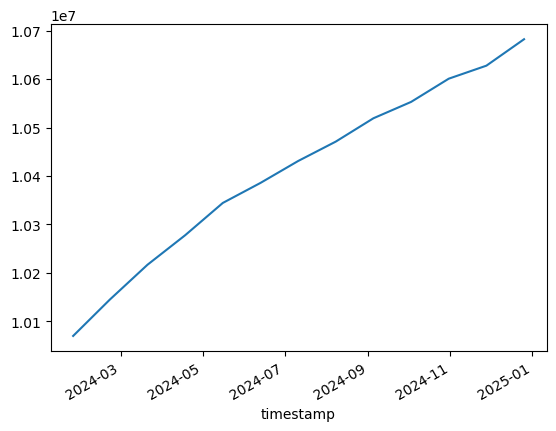

In [11]:
plot_df.dropna().total_capital.plot()

In [12]:
manager_ids = [m.manager_id for m in managers]
manager_ids

['CM_Risk', 'CM_Conservative']

<Axes: xlabel='timestamp'>

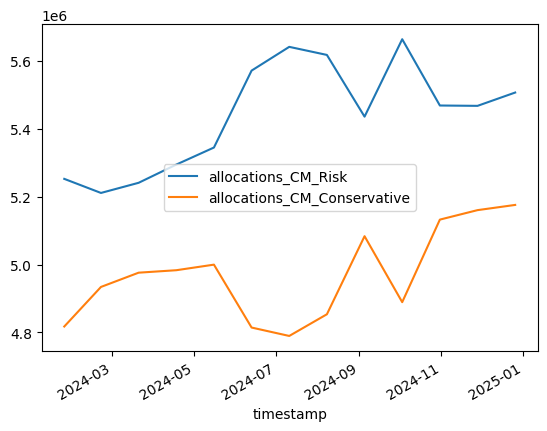

In [13]:
columns = [f'allocations_{m}' for m in manager_ids]
plot_df[columns].plot()

<Axes: xlabel='timestamp'>

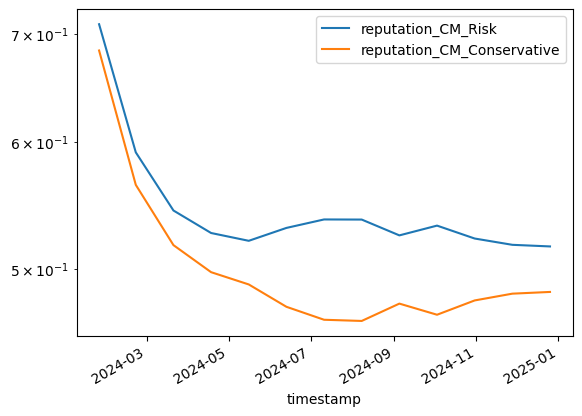

In [14]:
columns = [f'reputation_{m}' for m in manager_ids]
plot_df[columns].plot(logy=True)

<Axes: xlabel='timestamp'>

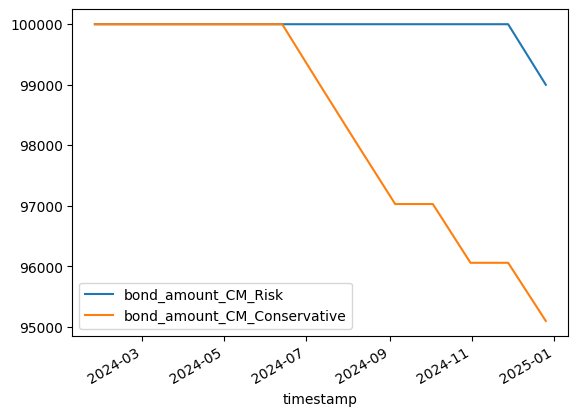

In [15]:
columns = [f'bond_amount_{m}' for m in manager_ids]
plot_df[columns].plot()

<Axes: xlabel='timestamp'>

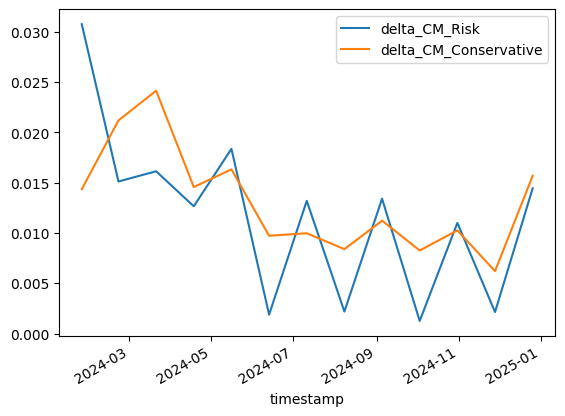

In [16]:
promised_yields_columns = [f'promised_yields_{m}' for m in manager_ids]
realized_yields_columns = [f'realized_yields_{m}' for m in manager_ids]

delta_cols = []
for m in manager_ids:
    plot_df[f'delta_{m}'] = (plot_df[f'promised_yields_{m}'] - plot_df[f'realized_yields_{m}']).abs()
    delta_cols.append(f'delta_{m}')


plot_df[delta_cols].plot()#(figsize=(10, 10), bins=30, range=(0, 0.03))